In [ ]:
# Take home challenge #2 - 
#Relax Inc Challenge

In [274]:
##Import libraries
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime



from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy


sns.set(style = 'whitegrid')
sns.set_palette('bright')
%matplotlib inline

# Cleaning and Loading data

In [184]:
# Read data
data_engagement = pd.read_csv("takehome_user_engagement.csv", )


In [185]:
# Explore the dataset
data_engagement.head(10)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1


In [186]:
# Explore the dataset
data_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [187]:
# Clean up the dataset
data_engagement['time_stamp'] = pd.to_datetime(data_engagement['time_stamp'], format = '%Y-%m-%d %H:%M:%S')
data_engagement['date'] = data_engagement['time_stamp'].dt.date
data_engagement['time'] = data_engagement['time_stamp'].dt.time

In [188]:
data_engagement.head(10)

,time_stamp,user_id,visited,date,time
0,2014-04-22 03:53:30,1,1,2014-04-22,03:53:30
1,2013-11-15 03:45:04,2,1,2013-11-15,03:45:04
2,2013-11-29 03:45:04,2,1,2013-11-29,03:45:04
3,2013-12-09 03:45:04,2,1,2013-12-09,03:45:04
4,2013-12-25 03:45:04,2,1,2013-12-25,03:45:04
5,2013-12-31 03:45:04,2,1,2013-12-31,03:45:04
6,2014-01-08 03:45:04,2,1,2014-01-08,03:45:04
7,2014-02-03 03:45:04,2,1,2014-02-03,03:45:04
8,2014-02-08 03:45:04,2,1,2014-02-08,03:45:04
9,2014-02-09 03:45:04,2,1,2014-02-09,03:45:04


In [189]:
# First determine the number of 'unique' users
print('The total number of unique users is {} out of {} logins.'.format(data_engagement['user_id'].nunique(), len(data_engagement)))

The total number of unique users is 8823 out of 207917 logins.


In [190]:
## Create a function to determine if the user is active or not. 
def calculate_delta_days (df, days= 7, logins = 3):
    #First removing any duplicate occurances of login andsort the date column in ascending order
    df = df.drop_duplicates(subset = 'date').sort_values('date')
    
    #Calculate a column which stores the delta date. Delta is calculated every 3rd period
    delta_days = df['date'].diff(periods = logins - 1)
    
    #Determine if any delta date is less than or equal to 7. 
    #The function returns True or False, True for active user and False for non active user
    return any(delta_days <= timedelta(days = days))


In [191]:
adopted_users = data_engagement.groupby('user_id').apply(calculate_delta_days)

In [192]:
print("Total number of adopted users is {}.".format(sum(active_users)))

Total number of adopted users is 1656.


In [193]:
### Explore the first dataset - takehome_users.csv

In [194]:
#Since the name and the email id columns contain some characters that are not in utf-8, let's drop those two columns and select only the rest
use_cols = ['object_id', 'creation_time','creation_source','last_session_creation_time','opted_in_to_mailing_list',
           'enabled_for_marketing_drip','org_id','invited_by_user_id']


data_users = pd.read_csv("takehome_users.csv", usecols = use_cols)

In [195]:
data_users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [196]:
## Explore the data_users file
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 750.1+ KB


There are some missing values in the last_session_creation_time and the invited_by_user id columns. Since we don't know any information on which user may have invited, we can ignore the missing values here. Since we also don't know the timestamp of last login, we can ignore the missing timestamps. Let's also convert the unix timestamp of last logint to datetime format. 

In [197]:
# First convert the last session creation time and creation time into YY-MM-DD-H-M-S format
data_users['last_session_creation_time']  = pd.to_datetime(data_users['last_session_creation_time'], unit = 's')
data_users['creation_time']  = pd.to_datetime(data_users['creation_time'], format='%Y-%m-%d %H:%M:%S')

In [198]:
data_users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [199]:
## Next we'll explore the org_id columns
data_users.groupby('org_id').count()['object_id'].sort_values(ascending = False)

org_id
0      319
1      233
2      201
3      168
4      159
      ... 
355      9
400      8
397      8
386      7
416      2
Name: object_id, Length: 417, dtype: int64

Since the invited_by_user_id column has a lot of missing values, we'll drop that column in our analysis.

In [200]:
## Drop invited_by_user_id
data_users.drop(['invited_by_user_id'], inplace=True, axis = 1)

Since there are several missing values in the last_session_creation_time, we can't estimate the exact number of days that a user has been active (i.e. last_session_creation_time - account_creation_time). Hence we drop this row as well. 

In [201]:
## Drop last_session_creation_time
data_users.drop(['last_session_creation_time'], inplace=True, axis = 1)

Next, we create a new feature as acc_age which is the age of the account. We can calculate this by taking the delta in days between account creation date and latest account creation date amongst all users. 

In [202]:
# Create acc_age
data_users['acc_age'] = ((max(data_users['creation_time'])) - data_users['creation_time']).dt.days

In [203]:
data_users.head()

,object_id,creation_time,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,acc_age
0,1,2014-04-22 03:53:30,GUEST_INVITE,1,0,11,38
1,2,2013-11-15 03:45:04,ORG_INVITE,0,0,1,196
2,3,2013-03-19 23:14:52,ORG_INVITE,0,0,94,437
3,4,2013-05-21 08:09:28,GUEST_INVITE,0,0,1,374
4,5,2013-01-17 10:14:20,GUEST_INVITE,0,0,193,498


In [204]:
#Drop the creation_time datetime columns

data_users.drop(['creation_time'], axis = 1, inplace=True)

In [205]:
data_users.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,acc_age
0,1,GUEST_INVITE,1,0,11,38
1,2,ORG_INVITE,0,0,1,196
2,3,ORG_INVITE,0,0,94,437
3,4,GUEST_INVITE,0,0,1,374
4,5,GUEST_INVITE,0,0,193,498


Next, we merge the data_users dataframe and the adopted_users series that we created on user_id/object_id. 

In [206]:
adopted_users = adopted_users.to_frame()
adopted_users.columns = ['is_adopted_user']
adopted_users.head()

,is_adopted_user
user_id,
1,False
2,True
3,False
4,False
5,False


In [207]:
#Reset the index
adopted_users.reset_index(inplace=True)
adopted_users.head()

In [213]:
# Next, merge the data_users and adopted_users on object_id on left and user_id on right
data = data_users.merge(adopted_users, left_on = 'object_id', right_on = 'user_id')

In [214]:
# Drop object_id or user_id since they are redundant
data.drop(['user_id'], axis =1 , inplace=True)
data.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,acc_age,is_adopted_user
0,1,GUEST_INVITE,1,0,11,38,False
1,2,ORG_INVITE,0,0,1,196,True
2,3,ORG_INVITE,0,0,94,437,False
3,4,GUEST_INVITE,0,0,1,374,False
4,5,GUEST_INVITE,0,0,193,498,False


The data_users dataframe originally had 12,000 users; adopted_users only had 8,823 unique user ids. However, since we don't have any information on the remaining users who are in data_users, but not in adopted_users, we'll ignore these rows, as we don't have any idea on whether a user is an adopted user or not. 

# Exploratory Data Analysis

## Account age by adopted user type

Text(0, 0.5, 'User history (days)')

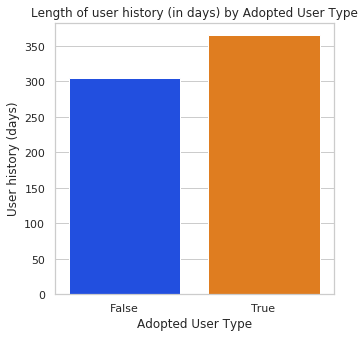

In [359]:
## Plot of average acc_age by adopted user type
data_acc_age = data.groupby('is_adopted_user').mean().reset_index()
fig, ax = plt.subplots(figsize = (5,5))
ax = sns.barplot(x ='is_adopted_user', y = 'acc_age', data = data_acc_age)
ax.set_title('Length of user history (in days) by Adopted User Type')
ax.set_xlabel('Adopted User Type')
ax.set_ylabel('User history (days)')

From the above plot, we see that an adopted user's average length of user history is higher than a user who is not adopted. 

In [362]:
data_acc_age

,is_adopted_user,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,acc_age,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,False,6013.700572,0.250733,0.151249,137.931771,304.574438,0.170085,0.364727,0.082601,0.222687,0.159900
1,True,6046.313406,0.259058,0.155193,162.655797,364.618357,0.222826,0.346618,0.103865,0.182367,0.144324


Text(0.5, 1.0, 'Adopted Users: False')

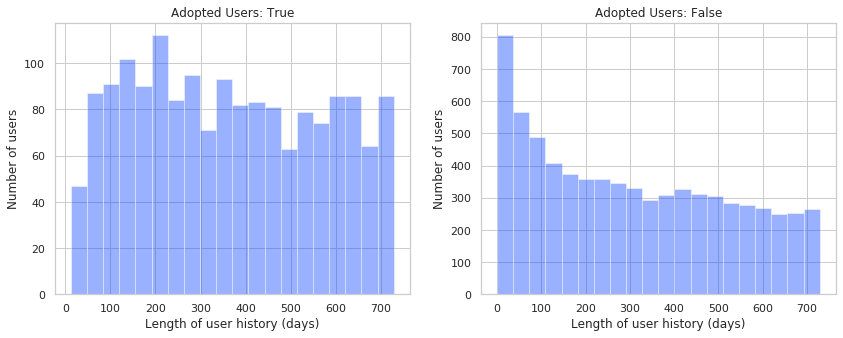

In [361]:
# Plot a histogram of acc_acg or length of user history by adopted user type
df_acc_age_true = data[data['is_adopted_user'] == True]
df_acc_age_false = data[data['is_adopted_user'] == False]


fig, ax = plt.subplots(1,2, figsize = (14,5))
df_acc_age_true['acc_age'].hist(alpha = 0.4, ax = ax[0], bins = 20)
df_acc_age_false['acc_age'].hist(alpha = 0.4, ax = ax[1], bins = 20)
ax[0].set_xlabel('Length of user history (days)')
ax[1].set_xlabel('Length of user history (days)')

ax[0].set_ylabel('Number of users')
ax[1].set_ylabel('Number of users')

ax[0].set_title('Adopted Users: True')
ax[1].set_title('Adopted Users: False')



#plt.xlabel('Length of user history (days)')


The above histogram indicates that an adopted user has an almost equal distribution of 'length of user history'. In other words, the number of adopted users with different length of user history as binned above are somewhat similar. But for the non-adopted users, we observe tha that the length of user history us very short (<100 days) for a large number of users. These would indicate users who are not interested in the product within 100 days of using it and eventually drop off. 

## Creation source by adopted user type

Text(0, 0.5, 'Count')

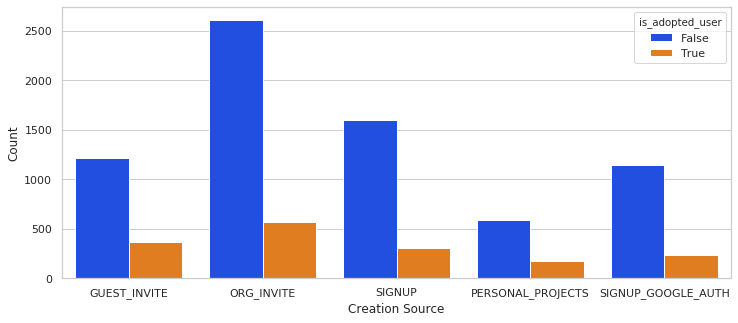

In [253]:
# Next, let's look at creation source by adopted user type
fig, ax = plt.subplots(figsize = (12,5))
ax = sns.countplot(x = 'creation_source', data = data, hue = 'is_adopted_user')
ax.set_xlabel('Creation Source')
ax.set_ylabel('Count')

Based on the above graph, we see that the creation source for each adopted user is highest by 'organizational invite' but there doesn't seem to be much of a difference between the other creation sources. 

In [254]:
# To confirm this, let us calculate the fraction of users who are adopted by creation source
data.groupby('creation_source')['is_adopted_user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.232368
ORG_INVITE            0.180050
PERSONAL_PROJECTS     0.225131
SIGNUP                0.159115
SIGNUP_GOOGLE_AUTH    0.172563
Name: is_adopted_user, dtype: float64

We see that more adopted users were invited by guese and personal projects than through organizations or signups. This makes sense since the choices of becoming a user are higher if someone recommended it to you, or you joined through a project. 

## Opted in to mailing list by adopted user type

Text(0, 0.5, 'Total count opted in to mailing list')

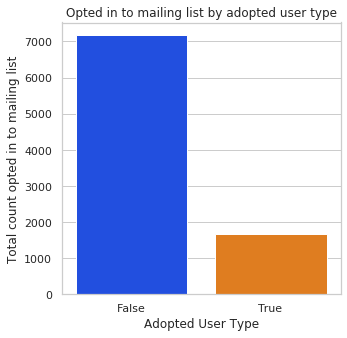

In [259]:
## Plot of average acc_age by adopted user type
opted_mail_list = data.groupby('is_adopted_user').count().reset_index()
fig, ax = plt.subplots(figsize = (5,5))
ax = sns.barplot(x ='is_adopted_user', y = 'opted_in_to_mailing_list', data = opted_mail_list )
ax.set_title('Opted in to mailing list by adopted user type')
ax.set_xlabel('Adopted User Type')
ax.set_ylabel('Total count opted in to mailing list')

The above graph shows that overall a lower number of adopted users opted in to mailing list. However, the total number of adopted users is much lower than the users who are not adopted. In order to confirm if there is a significant different in users who opted to mailing list, let's calculate the fraction of users to opted to mailing list.

In [262]:
data.groupby('opted_in_to_mailing_list')['is_adopted_user'].apply(lambda x: sum(x)/len(x))

opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: is_adopted_user, dtype: float64

## Enabled_for_marketing_drip by adopted user type

Text(0, 0.5, 'Total count enabled for marketing drip')

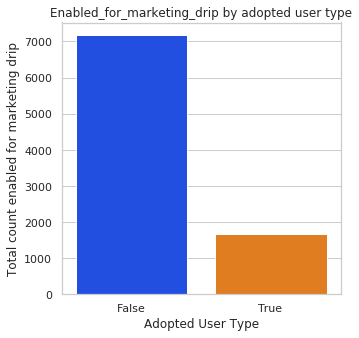

In [263]:
## Plot of average acc_age by adopted user type
marketing_drip = data.groupby('is_adopted_user').count().reset_index()
fig, ax = plt.subplots(figsize = (5,5))
ax = sns.barplot(x ='is_adopted_user', y = 'enabled_for_marketing_drip', data = marketing_drip )
ax.set_title('Enabled_for_marketing_drip by adopted user type')
ax.set_xlabel('Adopted User Type')
ax.set_ylabel('Total count enabled for marketing drip')[]

The above graph shows that overall a lower number of adopted users enabled marketing drip. However, the total number of adopted users is much lower than the users who are not adopted. In order to confirm if there is a significant different in users who opted to mailing list, let's calculate the fraction of users who enabled marketing drip.

In [264]:
data.groupby('enabled_for_marketing_drip')['is_adopted_user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: is_adopted_user, dtype: float64

Since the goal of this work is to determine which factors predict user adoption, we'll not build a full predictive model. Rather, we'll use **BorutaPy** which is used for performing feature selection for a predictive classification model. Another important point to note is here, the target variable is highly imbalanced due to relatively smaller number of adopted users.

# Determining important features

In [313]:
# First let's create dummy values for the creation_source column
data = pd.get_dummies(data) #Drop first dummy column, since it is correlated to the others

In [314]:
data.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,acc_age,is_adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,1,0,11,38,False,1,0,0,0,0
1,2,0,0,1,196,True,0,1,0,0,0
2,3,0,0,94,437,False,0,1,0,0,0
3,4,0,0,1,374,False,1,0,0,0,0
4,5,0,0,193,498,False,1,0,0,0,0


In [315]:
#Create the target variable and drop columns in the feature set that we don't need 
adopted = data['is_adopted_user']
df_features = data.drop(['is_adopted_user', 'object_id'], axis = 1)

Here I'm not performing and standard scaler transformation since the data distribution is not important here. 

In [316]:
# First define a random forest classifier, and set the class_weight to balanced. 

# The “balanced” mode uses the values of y to automatically adjust weights inversely 
#proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced')

#Next, define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)


# fit the model
feat_selector.fit(df_features.values, adopted.values)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	7


BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True,
                                          class_weight='balanced',
                                          criterion='gini', max_depth=None,
                                          max_features='auto',
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=42, n_jobs=-1,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7F60DCFB9D10,
                                          verbose=0, warm_start=False),
         max_iter=100, 

In [317]:
## Determine the column names in df_features
df_columns = df_features.columns.values

In [318]:
# Check feature ranking
df_features_ranking = pd.DataFrame(feat_selector.ranking_, index = df_columns)
df_features_ranking.columns = ['Rank']
df_features_ranking.sort_values('Rank', ascending = True)

,Rank
org_id,1
acc_age,1
opted_in_to_mailing_list,2
enabled_for_marketing_drip,3
creation_source_ORG_INVITE,4
creation_source_GUEST_INVITE,6
creation_source_SIGNUP,6
creation_source_SIGNUP_GOOGLE_AUTH,6
creation_source_PERSONAL_PROJECTS,8


The top 3 features for predicting whether a user is an 'adopted user' or not are  - **the organization id (organization a user belongs to), the age or length of user history in which the total time that a user has been active, whether or not the user opted in to the mailing list and whether the user enable for drop marketing**. The other features such as the account creation sourec are less important. 
